## Whats the big deal with imbalanced data?

In some cases, it can be very hard to learn from.

In [533]:
from imblearn.datasets import fetch_datasets

datasets = fetch_datasets()

# US crime dataset contains 100 features, descriptions found here: 
# http://archive.ics.uci.edu/ml/datasets/communities+and+crime
# Target class derived as target: >0.65
data = dataset['us_crime']
X, y = data.data, data.target

In [534]:
y = (y==1).astype(int)

#### Visualize dataset

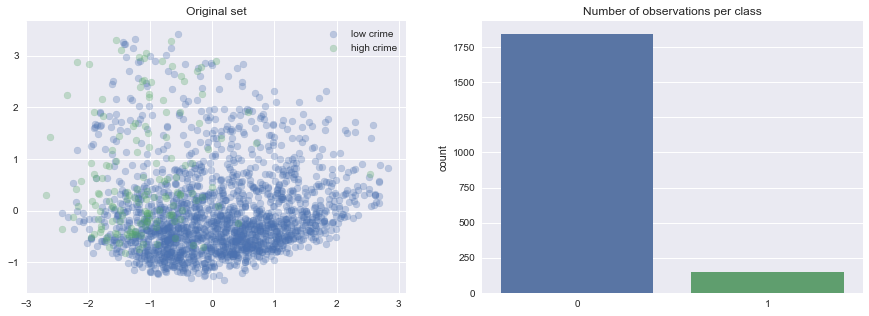

In [536]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="low crime", alpha=0.3)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="high crime", alpha=0.3)
ax[0].set_title('Original set')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Number of observations per class')

#### Train test split

In [457]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Build a pipeline for trying various sampling methods

In [540]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


def model_resampling_pipeline(X_train, X_test, y_train, y_test, model):
    results = {'ordinary': {},
               'class_weight': {},
               'oversample': {},
               'undersample': {}}
    
    # ------ No balancing ------
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['ordinary'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                          'fscore': fscore, 'n_occurences': support,
                          'predictions_count': Counter(predictions),
                          'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    
    
    # ------ Class weight ------
    if 'class_weight' in model.get_params().keys():
        model.set_params(class_weight='balanced')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

        results['class_weight'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                  'fscore': fscore, 'n_occurences': support,
                                  'predictions_count': Counter(predictions),
                                  'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}

    
    # ------------ OVERSAMPLING TECHNIQUES ------------
    # ------ Random oversampling ------
    sampler = RandomOverSampler()
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['oversample']['random_oversampler'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                                      'fscore': fscore, 'n_occurences': support,
                                      'predictions_count': Counter(predictions),
                                      'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    
    
    # ------ SMOTE oversampling ------
    sampler = SMOTE()
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['oversample']['smote'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                      'fscore': fscore, 'n_occurences': support,
                                      'predictions_count': Counter(predictions),
                                      'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    
    # ------ ADASYN oversampling ------
    sampler = ADASYN()
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['oversample']['adasyn'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                      'fscore': fscore, 'n_occurences': support,
                                      'predictions_count': Counter(predictions),
                                      'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    
    
    # ------------ UNDERSAMPLING TECHNIQUES ------------
    # ------ Random undersampling ------
    sampler = RandomUnderSampler()
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['undersample']['random_undersampler'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                      'fscore': fscore, 'n_occurences': support,
                                      'predictions_count': Counter(predictions),
                                      'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    
    # ------ Near miss 1 undersampling ------
    sampler = NearMiss(version=1)
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['undersample']['near_miss_1'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                              'fscore': fscore, 'n_occurences': support,
                                              'predictions_count': Counter(predictions),
                                              'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}

    # ------ Near miss 2 undersampling ------
    sampler = NearMiss(version=2)
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['undersample']['near_miss_2'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                              'fscore': fscore, 'n_occurences': support,
                                              'predictions_count': Counter(predictions),
                                              'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    
    # ------ Tomek Links undersampling ------
    sampler = TomekLinks()
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['undersample']['tomek_links'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                              'fscore': fscore, 'n_occurences': support,
                                              'predictions_count': Counter(predictions),
                                              'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    
    
    # ------ Edited nearest neighbors undersampling ------
    sampler = EditedNearestNeighbours()
    print('Before resampling: {}'.format(sorted(Counter(y_train).items())))
    X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
    print('After resampling: {}'.format(sorted(Counter(y_resampled).items())))

    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    results['undersample']['edited_nearest_neighbors'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                                          'fscore': fscore, 'n_occurences': support,
                                                          'predictions_count': Counter(predictions),
                                                          'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}

    return results

## Build tool to visualize results

In [543]:
def evaluate_method(results, method, metrics = ['precision', 'recall', 'fscore']):
    fig, ax = plt.subplots(1, 6, sharey=True, figsize=(16, 6))
    
    for i, metric in enumerate(metrics):
        ax[i*2].axhline(results['ordinary'][metric][0], label='no resampling')
        ax[i*2+1].axhline(results['ordinary'][metric][1], label='no resampling')
        if results['class_weight']:
            ax[i*2].bar(0, results['class_weight'][metric][0], label='adjust class weight')
            ax[i*2+1].bar(0, results['class_weight'][metric][1], label='adjust class weight')
        ax[0].legend(loc='upper center', bbox_to_anchor=(8, 1.01),
                     ncol=1, fancybox=True, shadow=True)
        for j, (technique, result) in enumerate(results[method].items()):
            ax[i*2].bar(j+1, result[metric][0], label=technique)
            ax[i*2].set_title(f'Low crime {metric}')


            ax[i*2+1].bar(j+1, result['fscore'][1], label=technique)
            ax[i*2+1].set_title(f'High crime {metric}')

## Try some models

In [538]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Random forest

In [524]:
model = RandomForestClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1481)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1455), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1345), (1, 120)]


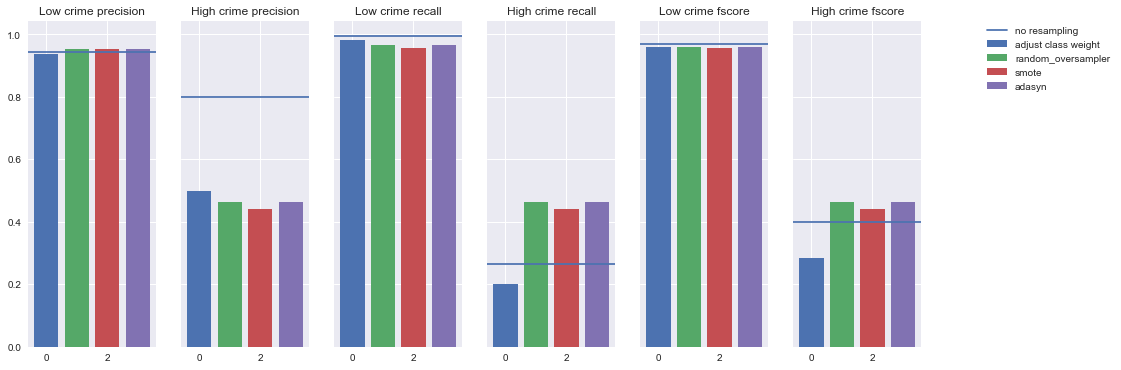

In [525]:
evaluate_method(results, 'oversample')

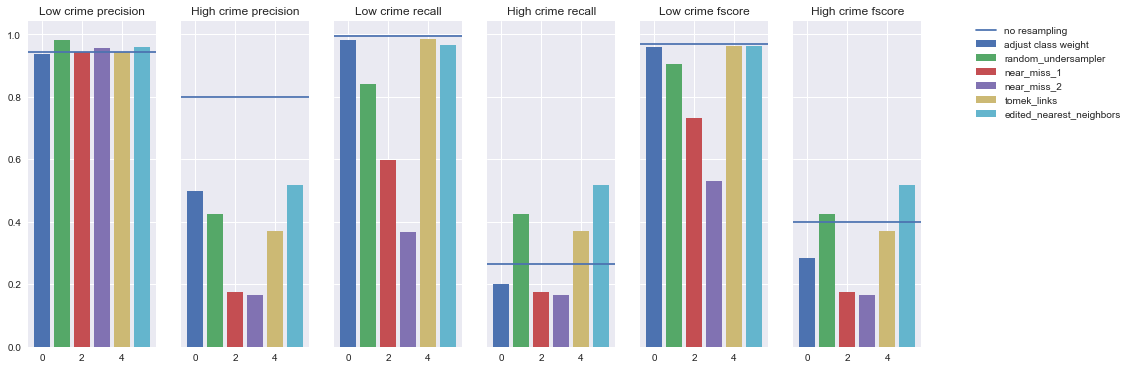

In [526]:
evaluate_method(results, 'undersample')

## Logistic regression

In [527]:
model = LogisticRegression()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1481)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1455), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1345), (1, 120)]


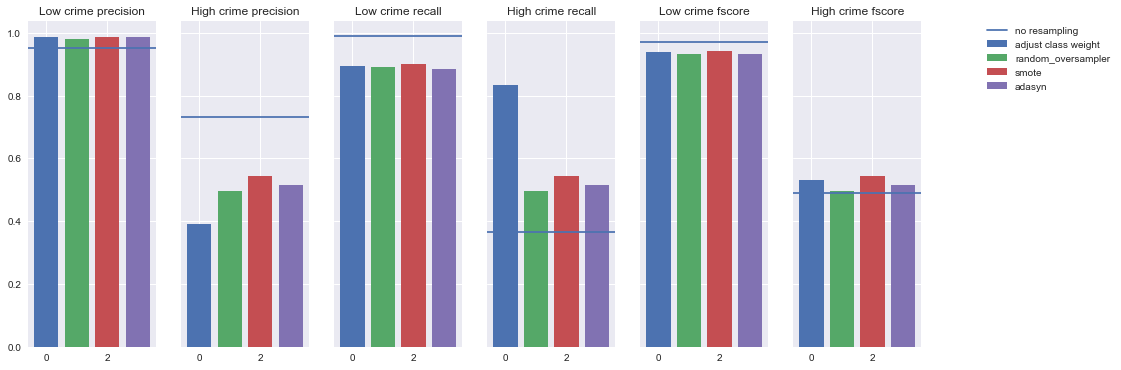

In [528]:
evaluate_method(results, 'oversample')

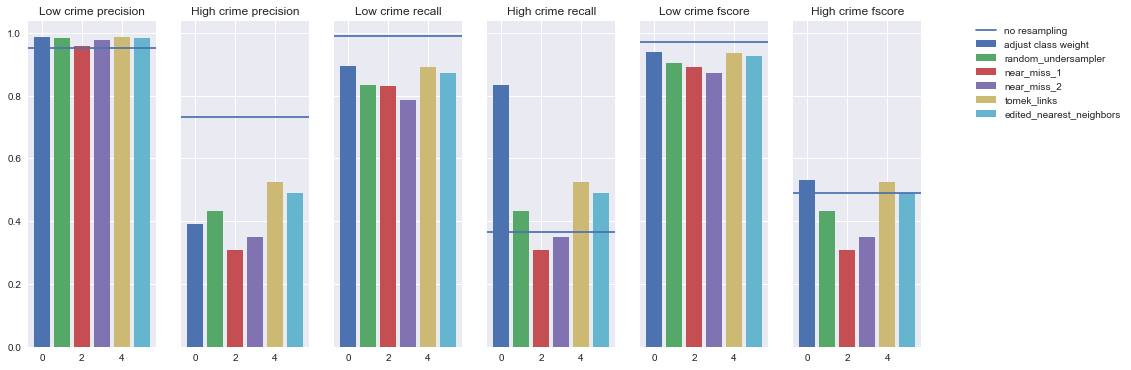

In [529]:
evaluate_method(results, 'undersample')

## SVM Classifier

In [530]:
model = SVC()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1481)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1455), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1345), (1, 120)]


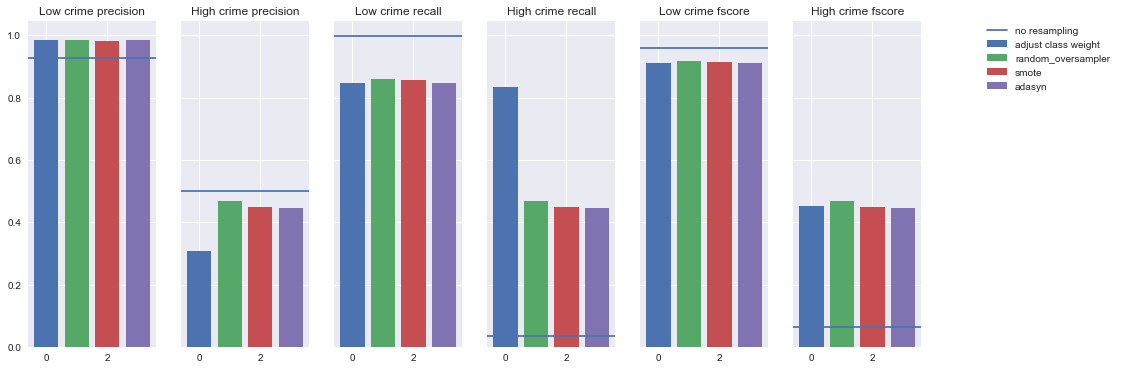

In [531]:
evaluate_method(results, 'oversample')

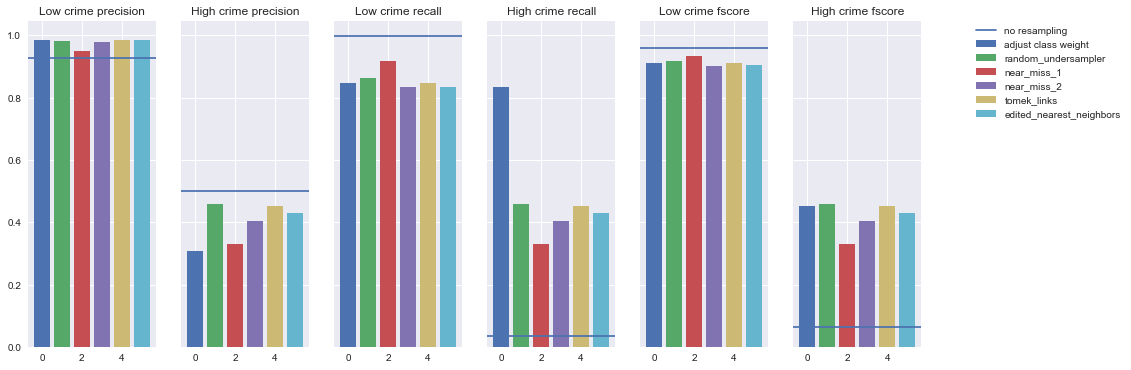

In [532]:
evaluate_method(results, 'undersample')

## KNN

In [541]:
model = KNeighborsClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1481)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1455), (1, 120)]
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1345), (1, 120)]


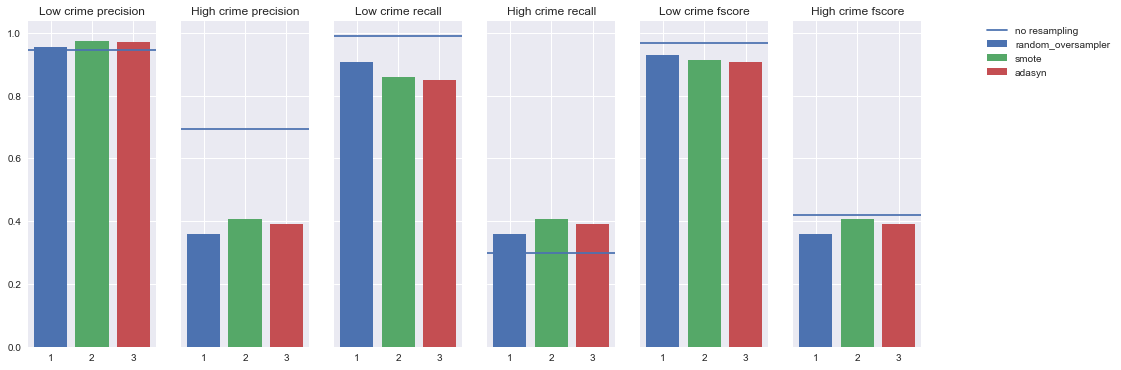

In [544]:
evaluate_method(results, 'oversample')

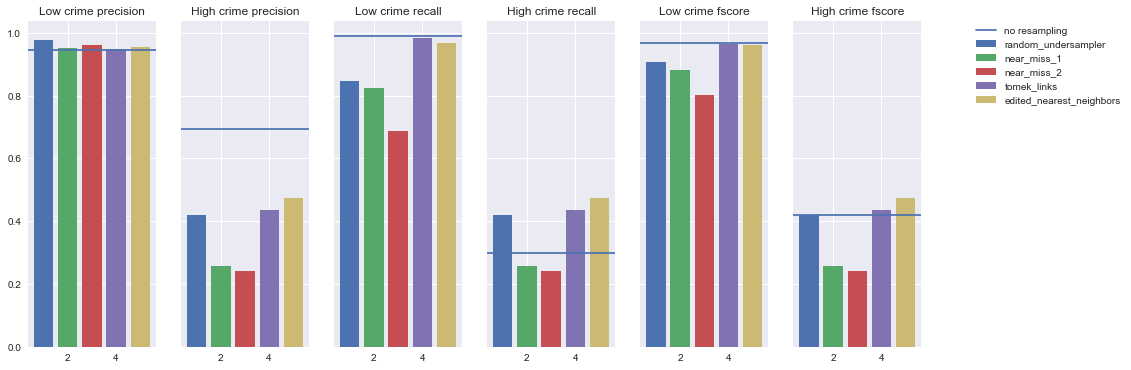

In [545]:
evaluate_method(results, 'undersample')

<hr>
# Techniques (implementation details)

## Assign a class weight (simplest solution)

The simplest solution towards addressing class imbalance is the find a weighting scheme such that all of the classes are equally important as a function of their frequency and individual weight. 

## Oversampling techniques

#### Random resampling of existing points

The simplest way to balance our classes would be to randomly duplicate observations from the minority classes until we've acheived balanced classes.

#### Generating new data points (oversampling)

There are two approaches supported for generating new data points, `SMOTE` (Synthetic Minority Over-sampling Technique) and `ADASYN` (Adaptive Synthetic Sampling). Both techniques use interpolation to generate new datapoints. 

For a given sample $x_i$, a new sample is generated by interpolating between on of the k-nearest neighbors.

$$x_{new} = x_i + \lambda (x_{zi} - x_i)$$

$\lambda$ is a random number in the range [0, 1]. This interpolation will create a sample on the line between $x_{i}$ and $x_{zi}$.

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_generation_sample_0011.png" alt="Drawing" style="width: 400px;"/>

The main distinction between these two methods (as discussed below) is how $x_i$ is chosen. 

#### SMOTE

This algorithm has three options for selecting $x_i$.

1. `regular`: No selection rules, randomly sample all possible $x_i$.
2. `borderline`: Separates all possible $x_i$ into three classes using the k nearest neighbors of each point.
    - *noise*: all nearest-neighbors are from a different class than $x_i$
    - *in danger*: at least half of the nearest neighbors are of the same class as $x_i$
    - *safe*: all nearest neighbors are from the same class as $x_i$
3. `svm`: Uses an SVM classifier to identify the support vectors (samples close to the decision boundary) and samples $x_i$ from these points. 

###### ADASYN

Adasyn selects samples similar to SMOTE, but it will generate more artificial samples from $x_i$s which are nearby to other classes. 

## Undersampling techniques

#### Random undersampling to balance out the classes

#### Near miss

The general idea behind near miss is to only the sample the points from the majority class necessary to distinguish between other classes.

**NearMiss-1** select samples from the majority class for which the average distance of the N *closest* samples of a minority class is smallest. 

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_nearmiss_0011.png" alt="Drawing" style="width: 400px;"/>

**NearMiss-2** select samples from the majority class for which the average distance of the N *farthest* samples of a minority class is smallest. 

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_nearmiss_0021.png" alt="Drawing" style="width: 400px;"/>

#### Tomek’s links

A Tomek’s link between two observations of different classes ($x$ and $y$) is defined such that there is no example $z$ such that:

$$d(x, y) < d(x, z) \text{ or } d(y, z) < d(x, y)$$

where $d()$ is the distance between the two samples. **In other words, a Tomek’s link exist if the two observations of different classes are the nearest neighbors of each other.** In the figure below, a Tomek’s link is illustrated by highlighting the samples of interest in green.

<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_illustration_tomek_links_0011.png" alt="Drawing" style="width: 400px;"/>

If a Tomek link is found, the observation from the majority class is removed.

#### Edited nearest neighbors

EditedNearestNeighbours applies a nearest-neighbors algorithm and “edit” the dataset by removing samples which do not agree “enough” with their neighboorhood. For each sample in the class to be under-sampled, the nearest-neighbours are computed and if the selection criterion is not fulfilled, the sample is removed.